<a href="https://colab.research.google.com/github/andjelatodorovich/Autoencoder/blob/master/Grayscale_image_restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow-gpu==2.0

In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.7.0


In [3]:
# !pip install Pillow==8.4.0

In [4]:
import os
import cv2
import numpy as np
import re
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/grayscales'
print(path)

/content/drive/MyDrive/grayscales


In [7]:
train_path = '/content/drive/MyDrive/grayscales/train'
test_path = '/content/drive/MyDrive/grayscales/test'

In [8]:
def make_dataset(kind_of_data) :
    X = []
    if kind_of_data == 'train' :
        new_path = train_path
    elif kind_of_data == 'test' :
        new_path = test_path
    else :
        return 0
    
    
    #image_in_folder = [f for f in os.listdir(new_path) if re.match(r'[0-9]+.*\.jpg', f)]
    image_in_folder = os.listdir(new_path)
    print(len(image_in_folder))
    for i in range(len(image_in_folder)):
        img = tf.keras.preprocessing.image.load_img(
        new_path+'/'+str(image_in_folder[i]), color_mode='grayscale', target_size=None,
        interpolation='nearest' )
        img = keras.preprocessing.image.img_to_array(img)
        img = img/255
        if (img.shape == (128,128,1)):
          X.append(img)
              
    return X

In [9]:
x_train = make_dataset('train')
x_test = make_dataset('test')

4907
2214


In [10]:
formatxy = (128,128)

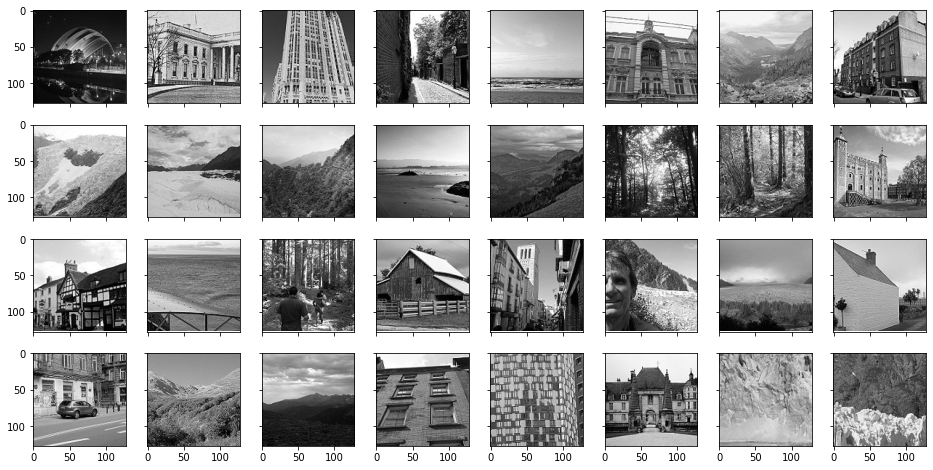

In [11]:
sample_images = x_train[:100]

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, img in zip(grid, sample_images):
  ax.imshow(img.reshape(formatxy), cmap = "gray")

plt.show()

In [12]:
maxElement_train = max(arr.max() for arr in x_train)
maxElement_test = max(arr.max() for arr in x_test)
maxElement = np.amax(np.array(maxElement_train, maxElement_test))
maxElement

1.0

In [13]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(128, 128), n_channels=1, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()
      for image in X:
        image = image*255
      for image in y:
        image = image*255
  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((32, 128, 128,1)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((32, 128, 128,1)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)

      X_batch[i,] = masked_image
      y_batch[i] = self.y[idx]
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    masked_image = img.copy()
    for _ in range(int(0.5*(128*128))):
      # Get random x locations to start line
      x1, y1 = np.random.randint(1, 127), np.random.randint(1, 127)
      masked_image[x1,y1] = 0
    return masked_image

In [14]:
def createMask(img):
    ## Prepare masking matrix
    masked_image = img.copy()
    for _ in range(int(0.5*(128*128))):
      # Get random x locations to start line
      x1, y1 = np.random.randint(1, 128), np.random.randint(1, 128)
      masked_image[x1,y1] = 0
    return masked_image

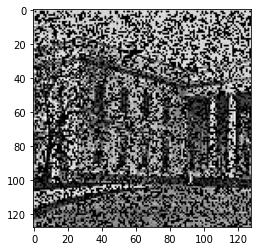

In [15]:
plt.imshow(createMask(sample_images[1].reshape(formatxy)), cmap='gray')

In [16]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

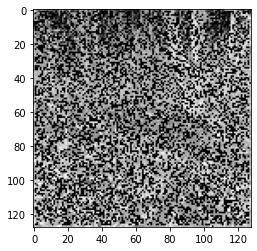

In [17]:
## Examples
sample_idx = 10 ## Change this to see different batches
sample_images1, sample_masks1 = traingen[sample_idx]
im = sample_images1[0]*255*255
im = im.astype(np.uint8)
plt.imshow(im.reshape(formatxy), cmap = 'gray')

In [18]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [19]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(128,128,1)):
    inputs = keras.layers.Input(input_size)
    print(inputs.shape)
    conv1, pool1 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(512, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(1024, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(1024, 1024, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(512, 512, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(256, 256, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(128, 128, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [20]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

(None, 128, 128, 1)


In [27]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=10, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen))

Epoch 1/10
153/153 [==============================] - 577s 4s/step - loss: 0.0309 - dice_coef: 0.5922 - val_loss: 0.0301 - val_dice_coef: 0.5910
Epoch 2/10
153/153 [==============================] - 571s 4s/step - loss: 0.0290 - dice_coef: 0.5922 - val_loss: 0.0288 - val_dice_coef: 0.5858
Epoch 3/10
153/153 [==============================] - 573s 4s/step - loss: 0.0305 - dice_coef: 0.5924 - val_loss: 0.0298 - val_dice_coef: 0.5855
Epoch 4/10
153/153 [==============================] - 575s 4s/step - loss: 0.0291 - dice_coef: 0.5928 - val_loss: 0.0311 - val_dice_coef: 0.5855
Epoch 5/10
153/153 [==============================] - 574s 4s/step - loss: 0.0288 - dice_coef: 0.5930 - val_loss: 0.0318 - val_dice_coef: 0.5980
Epoch 6/10
153/153 [==============================] - 572s 4s/step - loss: 0.0275 - dice_coef: 0.5932 - val_loss: 0.0257 - val_dice_coef: 0.5896
Epoch 7/10
153/153 [==============================] - 569s 4s/step - loss: 0.0252 - dice_coef: 0.5934 - val_loss: 0.0260 - val_dic

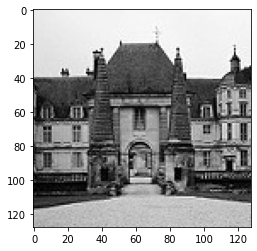

In [76]:
plt.imshow(sample_images[29].reshape(128,128), cmap = 'gray')

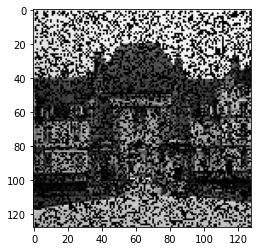

In [78]:
masked_image1 = createMask(sample_images[29])
plt.imshow(masked_image1.reshape(128,128), cmap = 'gray')

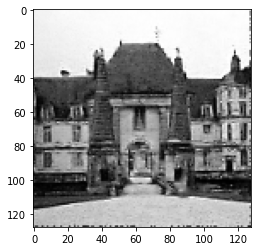

In [79]:
resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
res = resulting.reshape(resulting.shape[1:])
plt.imshow(res.reshape(128,128), cmap = 'gray')

In [44]:
for i in range(100):
  path1 = os.path.join(path,str(i)+'_groundtruth.jpg')
  path2 = os.path.join(path,str(i)+'_masked.jpg')
  path3 = os.path.join(path,str(i)+'_restrored.jpg')

  plt.imsave(path1, sample_images[i].reshape(128,128), cmap = 'gray')
  masked_image1 = createMask(sample_images[i])
  plt.imsave(path2, masked_image1.reshape(128,128), cmap = 'gray')
  resulting = model.predict(masked_image1.reshape((1,)+masked_image1.shape))
  res = resulting.reshape(resulting.shape[1:])
  plt.imsave(path3, res.reshape(128,128), cmap = 'gray')

In [80]:
loss = np.linalg.norm(resulting - sample_images[29])/(128*128)
print(loss)

0.000575247744563967
